# Neural Style Transfer - Complete Walkthrough
**From Theory to Implementation**

This notebook explains and implements Johnson's Fast Neural Style Transfer using PyTorch.  
By the end, you'll be able to:
- Understand content/style representation in CNNs
- Calculate Gram matrices for style loss
- Perform style transfer on your own images

## 1. Setup and Imports
First, let's import required libraries and configure our environment.

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os

warnings.filterwarnings('ignore')

# Check for GPU availability
if torch.backends.mps.is_available():
    device = torch.device("mps")    # for Apple Silicone
elif torch.cuda.is_available():
    device = torch.device("cuda")   # for Nvidia
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 2. Image Preprocessing
Neural networks expect normalized tensors as input.  
We need to:
1. Resize images to consistent dimensions
2. Convert to PyTorch tensors
3. Normalize with ImageNet stats

In [83]:
def load_image(img_path, max_size=512):
    """
    Load and preprocess image for VGG19 network
    
    Args:
        img_path: Path to image file
        max_size: Maximum dimension for resizing
    
    Returns:
        Normalized image tensor (1, 3, H, W)
    """
    image = Image.open(img_path).convert('RGB')
    
    # Calculate new dimensions while preserving aspect ratio
    size = min(max_size, max(image.size))
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Add batch dimension (B, C, H, W)
    image = transform(image).unsqueeze(0)
    return image.to(device)

def imshow(tensor, title=None):
    """
    Convert tensor to PIL image and display
    
    Args:
        tensor: (1, 3, H, W) normalized tensor
        title: Optional plot title
    """
    # Clone and detach from computation graph
    image = tensor.cpu().detach().clone().squeeze(0)  # Changed here
    
    # Reverse normalization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = inv_normalize(image)
    
    # Convert to numpy and clip values
    image = image.numpy()  # Now safe
    image = np.clip(image, 0, 1)
    plt.imshow(image.transpose(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')

## 3. Model Initialization
We'll use VGG19's feature extractor (without classifier) as our loss network.
Key points:
- We freeze all VGG19 parameters
- Only need certain layers for style/content representation

In [84]:
def get_vgg():
    """
    Initialize pretrained VGG19 with frozen parameters
    
    Returns:
        VGG19 feature extractor
    """
    vgg = models.vgg19(pretrained=True).features
    for param in vgg.parameters():
        param.requires_grad_(False)
    return vgg.to(device)

vgg = get_vgg()
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Feature Extraction
We'll extract features from specific layers:
- Style layers: Multiple layers to capture texture at different scales
- Content layer: Single layer to preserve structure

In [85]:
def get_features(x, model, layers=None):
    """
    Extract features from target VGG19 layers
    
    Args:
        x: Input image tensor
        model: VGG19 feature extractor
        layers: Dict of layer names to extract
        
    Returns:
        Dictionary of layer_name: feature_tensor
    """
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content representation
            '28': 'conv5_1'
        }
    
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

## 5. Gram Matrix Calculation
The Gram matrix captures style by measuring feature correlations:
- Flattens spatial dimensions
- Computes inner product between feature maps
- Normalizes by number of elements

In [86]:
def gram_matrix(tensor):
    """
    Compute Gram matrix for style representation
    
    Args:
        tensor: Feature tensor (1, C, H, W)
        
    Returns:
        Normalized Gram matrix (C, C)
    """
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (c * h * w)

## 6. Style Transfer Implementation
Now we combine everything into the complete algorithm:
1. Load content and style images
2. Initialize target image
3. Extract features
4. Calculate losses
5. Optimize target image

In [87]:
def style_transfer(
        content_path, 
        style_path, 
        epochs=300, 
        content_weight=1, 
        style_weight=1e6,
        show_every=50
    ):
    """
    Complete style transfer pipeline
    
    Args:
        content_path: Path to content image
        style_path: Path to style image
        epochs: Number of optimization iterations
        content_weight: α (content loss importance)
        style_weight: β (style loss importance)
        show_every: Display progress every N epochs
        
    Returns:
        Stylized image tensor
    """
    # Load images
    content = load_image(content_path)
    style = load_image(style_path)
    
    # Initialize target image
    target = torch.nn.Parameter(content.clone())
    
    # Get features
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)
    
    # Style Gram matrices (precompute once)
    style_grams = {layer: gram_matrix(style_features[layer]) 
                  for layer in style_features}
    
    # Optimizer (LBFGS often better but Adam more stable)
    optimizer = optim.Adam([target], lr=0.01)
    
    # Loss tracking
    style_loss_hist = []
    content_loss_hist = []
    
    print("Starting optimization...")
    for epoch in range(1, epochs+1):
        
        def closure():
            """Required for LBFGS, but we use Adam so just pass"""
            return 1
        
        # Forward pass
        target_features = get_features(target, vgg)
        
        # Content loss (MSE at conv4_2)
        content_loss = torch.mean(
            (target_features['conv4_2'] - content_features['conv4_2'])**2
        )
        
        # Style loss (Gram matrix MSE at multiple layers)
        style_loss = 0
        for layer in ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']:
            target_gram = gram_matrix(target_features[layer])
            style_gram = style_grams[layer]
            style_loss += torch.mean((target_gram - style_gram)**2)
        
        # Total loss
        total_loss = content_weight * content_loss + style_weight * style_loss
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Track losses
        style_loss_hist.append(style_loss.item())
        content_loss_hist.append(content_loss.item())
        
        # Display progress
        if epoch % show_every == 0:
            print(f"Epoch {epoch}/{epochs}")
            print(f"Content Loss: {content_loss.item():.4f}")
            print(f"Style Loss: {style_loss.item():.4f}")
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 3, 1)
            imshow(content, "Content")
            
            plt.subplot(1, 3, 2)
            imshow(style, "Style")
            
            plt.subplot(1, 3, 3)
            imshow(target, "Target")
            
            plt.show()
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(style_loss_hist, label="Style Loss")
    plt.plot(content_loss_hist, label="Content Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    return target

## 7. Running the Algorithm
Let's test with sample images.  
**Note**: First run will download VGG19 (~500MB).

Starting optimization...
Epoch 50/500
Content Loss: 4.2486
Style Loss: 0.0002


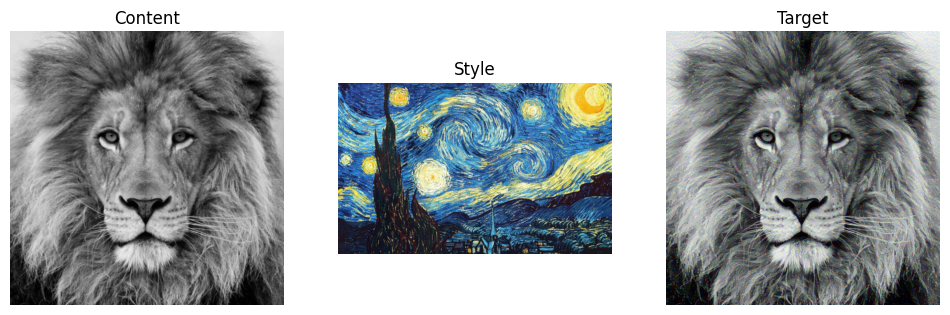

Epoch 100/500
Content Loss: 3.9229
Style Loss: 0.0001


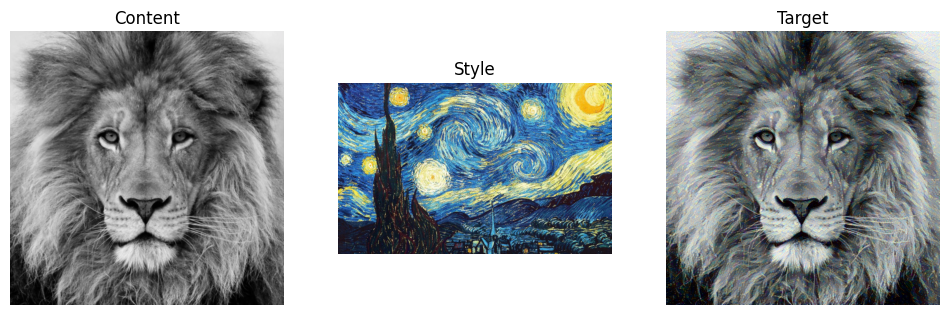

Epoch 150/500
Content Loss: 3.7623
Style Loss: 0.0001


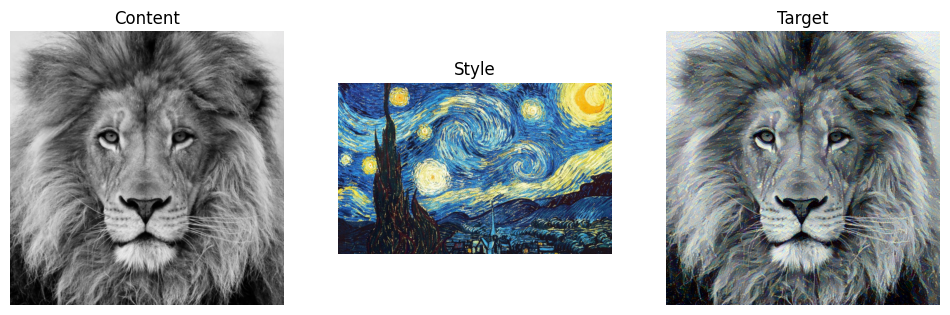

Epoch 200/500
Content Loss: 3.7160
Style Loss: 0.0001


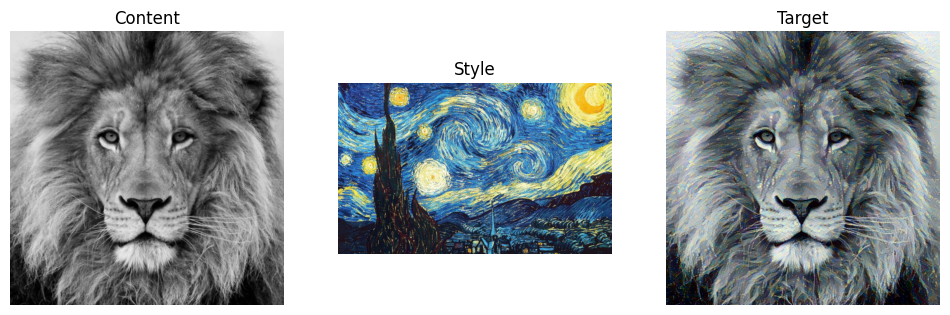

Epoch 250/500
Content Loss: 3.5017
Style Loss: 0.0001


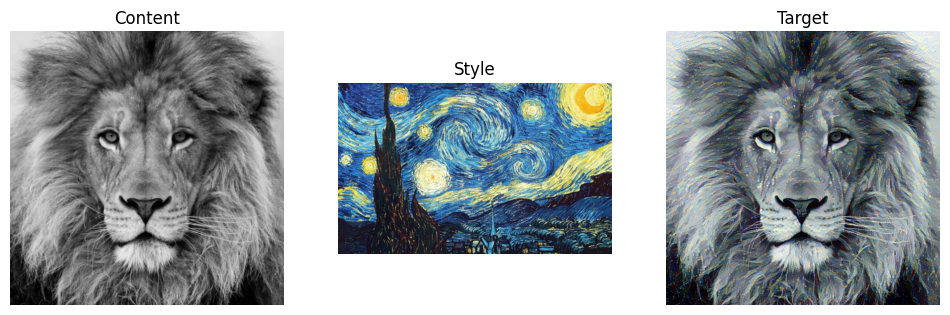

Epoch 300/500
Content Loss: 3.4304
Style Loss: 0.0001


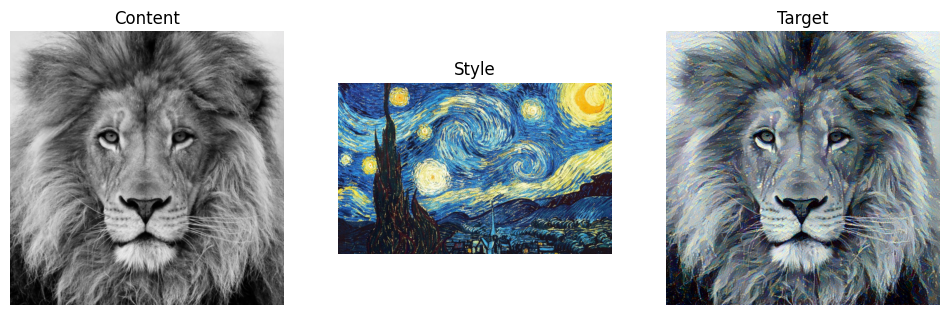

Epoch 350/500
Content Loss: 3.4221
Style Loss: 0.0001


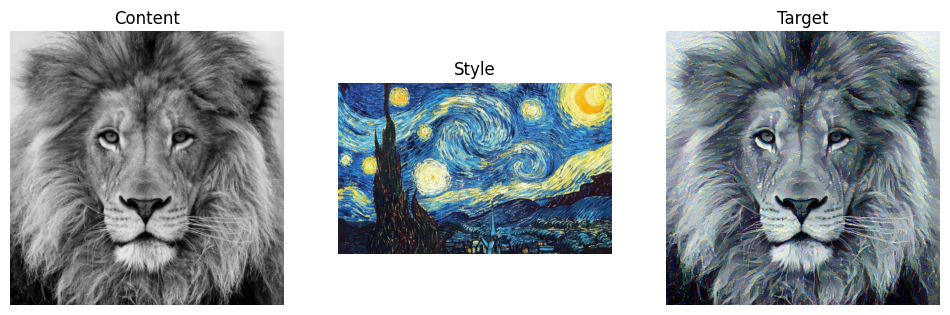

Epoch 400/500
Content Loss: 3.3971
Style Loss: 0.0001


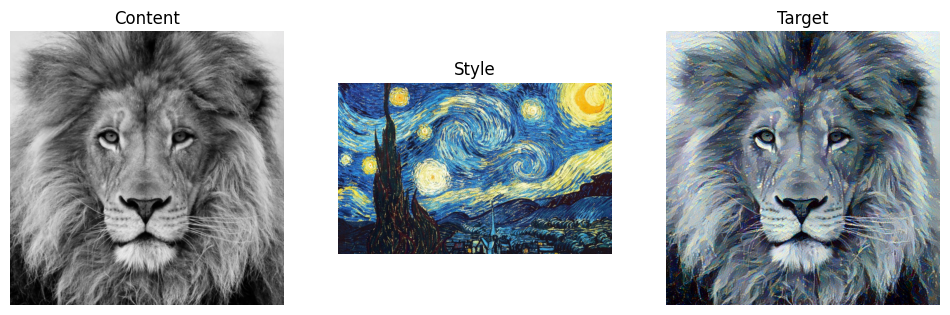

Epoch 450/500
Content Loss: 3.3872
Style Loss: 0.0001


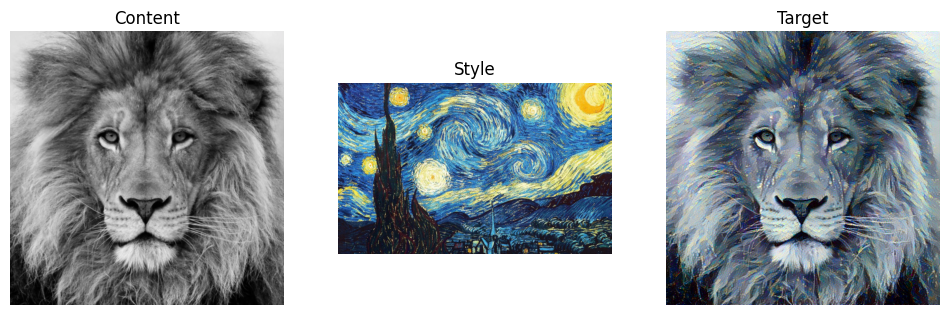

Epoch 500/500
Content Loss: 3.3327
Style Loss: 0.0001


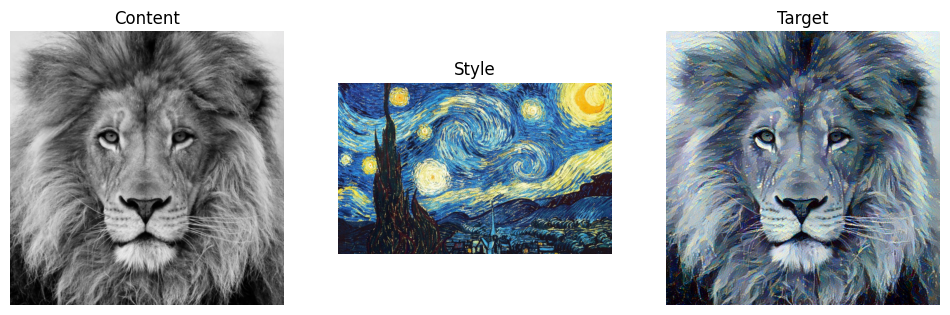

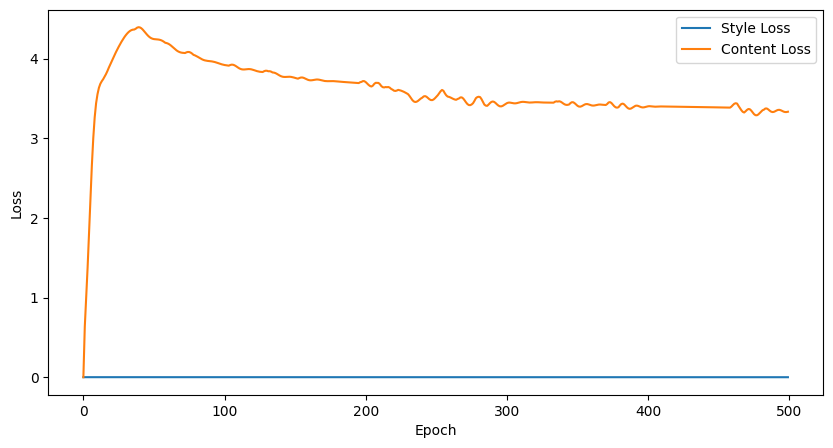

Saved stylized image to ./data/output/stylized_final.jpg


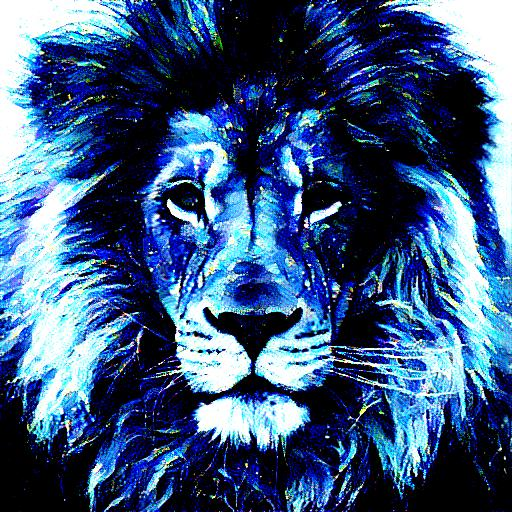

In [ ]:
# Example paths (modify as needed)
content_path = "./data/input/lion.jpg"
style_path = "./data/styles/vg_starry_night.jpg"

# Example values (modeify as needed)
epochs = 500
content_weight = 1
style_weight = 4e5

# Verify paths exist
if not os.path.exists(content_path):
    raise FileNotFoundError(f"Content image not found at {content_path}")
if not os.path.exists(style_path):
    raise FileNotFoundError(f"Style image not found at {style_path}")

# Run style transfer (reduce epochs for quick testing)
try:
    output = style_transfer(
        content_path=content_path,
        style_path=style_path,
        epochs=epochs,
        content_weight=content_weight,
        style_weight=style_weight
    )
    
    # Save result
    output_image = output.cpu().detach().clone().squeeze(0).clamp(0, 1)

    # Convert to PIL and save
    final_image = transforms.ToPILImage()(output_image)
    final_image.save("./data/output/stylized_final.jpg")
    print("Saved stylized image to ./data/output/stylized_final.jpg")

    from IPython.display import display
    from PIL import Image

    display(Image.open("./data/output/stylized_final.jpg"))
    
except RuntimeError as e:
    print(f"Error during style transfer: {str(e)}")
    if "CUDA out of memory" in str(e):
        print("Try reducing image size or using CPU")

## 8. Advanced Topics
### Hyperparameter Tuning
- **Style Weight (β)**: Higher values emphasize style more
- **Content Weight (α)**: Higher values preserve content structure
- **Layer Selection**: Deeper layers capture more abstract features

### Performance Tips
- Use higher `epochs` (500-1000) for better results
- Try LBFGS optimizer (better but less stable)
- Pre-resize images to similar dimensions

## 9. Why Use Pretrained Models? 
### (Limitations of Optimization-based NST)

While the algorithm we've implemented here (Gatys et al., 2015) is conceptually powerful and flexible, it comes with **significant limitations** in real-world applications:

### ❌ Limitations of Optimization-based Style Transfer:

1. **Extremely Slow**  
   - Each image stylization is a separate optimization problem.
   - Even with GPU acceleration, it takes **minutes per image**, as each pixel is being refined via gradient descent.

2. **Computationally Expensive**  
   - Needs **hundreds of forward/backward passes** through a deep network (like VGG19).
   - Consumes large amounts of memory and GPU time.

3. **Not Scalable for Batch or Video**  
   - Processing a directory or video frame-by-frame with this method is **impractical**.
   - Stylizing a 10-second video at 30 FPS would require optimizing **300 separate images**.

4. **No Real-Time Capability**  
   - Cannot be used in interactive applications like webcam filters or mobile apps.



### ✅ Why Use Pretrained Feed-Forward Models (Johnson et al., 2016)?

To overcome these limitations, modern implementations use **pretrained transformer networks**, which:

- Stylize images in **one single forward pass**
- Are trained **once per style** using the Gatys-style loss
- Can process images or videos in **real time**
- Are ideal for **apps, video, live style transfer**, and batch jobs

This is exactly what our `stylization_script.py` does:  
It loads a **pretrained style model** and applies the learned transformation directly to new content images — no optimization or tuning needed.

## 10. Takeaway

| Method                        | Flexibility | Speed     | Practical Use     |
|------------------------------|-------------|-----------|-------------------|
| **Gatys-style** (Notebook)   | ✅ High      | ❌ Slow    | 🚫 Not practical   |
| **Johnson-style** (Pretrained) | ❌ One style/model | ✅ Real-time | ✅ Ideal for deployment |

For creative experimentation or learning, the Gatys-style method is excellent.  
But for any production-ready or interactive application, **pretrained models are the standard**.